# Implementing New Representations

As our solver treats objects very generally, implementing new representations is surprisingly easy. To implement a new [Representation](https://emlp.readthedocs.io/en/latest/package/emlp.solver.reps.html#emlp.reps.Rep) you need to implement a `rho(M)` which is a mapping from the group elements to the representation matrix, as well as make sure to specify a `self.G` attribute for the given symmetry group. It's also a good idea to implement a `__str__` function to improve readability. You can optionally specify `self.is_permutation=True` if the representation acts as a permutation matrix, which enables pointwise Swish nonlinearities in EMLP.

We will automatically generate implementations of `drho(A)` using autograd, as well as some bookkeeping functions `size()` which is the dimension of the representation, `__eq__` and `__hash__` for distinguishing different representations. In some fringe cases you may want to implement your own `__eq__` and `__hash__` functions.

## Example 1: Irreducible Representations of SO(2) 

As a first example, we show one can implement the real irreducible representations of the group SO(2). All of irreducible representations $\psi_n$ of SO(2) are $2$-dimensional (except for $\psi_0$ which is the same as [Scalar](https://emlp.readthedocs.io/en/latest/package/emlp.reps.html#emlp.reps.Scalar) $= \mathbb{R} = \psi_0$). These representations can be written $\psi_n(R_\theta) = \begin{bmatrix}\cos(n\theta) &\sin(n\theta)\\-\sin(n\theta) &  \cos(n\theta) \end{bmatrix}$ or simply: $\psi_n(R) = R^n$.

In [1]:
import jax.numpy as jnp
from emlp.reps import Rep,vis,V,equivariance_error
from emlp.groups import SO,S

class SO2Irreps(Rep):
    """ (Real) Irreducible representations of SO2 """
    def __init__(self,order):
        assert order>0, "Use Scalar for 𝜓₀"
        self.G=SO(2)
        self.order = order
    def rho(self,M):
        return jnp.linalg.matrix_power(M,self.order)
    def __str__(self):
        number2sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
        return f"𝜓{self.order}".translate(number2sub)

That's it! Now we can use the SO(2) irreps in the type system, and solve for equivariant bases that contain them.

In [2]:
psi1 = SO2Irreps(1)
psi2 = SO2Irreps(2)
psi3 = SO2Irreps(3)

In [3]:
psi1*psi2+psi3

𝜓₃+𝜓₂⊗𝜓₁

We can verify [schur's lemma](https://en.wikipedia.org/wiki/Schur%27s_lemma), that there are no nontrivial equivariant linear maps from one irrep to another:

In [4]:
print((psi1>>psi2).equivariant_basis(),(psi2>>psi3).equivariant_basis(),(psi1>>psi3).equivariant_basis())

[] [] []


And we can include non irreducibles in our representation too. For example computing equivariant maps from $T_4 \rightarrow \psi_2$.

V⁴⊗𝜓₂ equivariant maps with r=8 basis elements


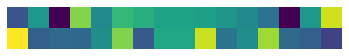

In [5]:
vis(V(SO(2))**4,psi2,False)
Wrep = V(SO(2))**4>>psi2
Q = Wrep.equivariant_basis()
print("{} equivariant maps with r={} basis elements".format(Wrep,Q.shape[-1]))

In [6]:
import numpy as np
W = Q@np.random.randn(Q.shape[-1])
print("With equivariance error {:.2e}".format(equivariance_error(W,V(SO(2))**4,psi2,SO(2))))

With equivariance error 1.56e-07


## Example 2: PseudoScalars, PseudoVectors, and PseudoTensors

With a slightly more sophisticated example, we'll now implement the representations known as [PseudoScalars](https://en.wikipedia.org/wiki/Pseudoscalar), [PseudoVectors](https://en.wikipedia.org/wiki/Pseudovector), and other PseudoTensor representations. These representations commonly occur in physics when working with cross products or the Hodge star, and also describe the Fermi statistics of spin 1/2 particles that are antisymmetric under exchange.

A pseudoscalar is like a scalar `Scalar` $=\mathbb{R}$, but incurs a $-1$ under orientation reversing transformations: $\rho(M) = \mathrm{sign}(\mathrm{det}(M))$. Similarly, pseudovectors are like ordinary vectors but can pick up this additional $-1$ factor. In fact, we can convert any representation into a pseudorepresentation by multiplying by a pseudoscalar.

<!-- For when the group $G$ is the symmetric group $S_n$, the sign of the determinant of the permutation matrices $\sigma\in G$ is nothing but the parity of the permutation $(-1)^{N(\sigma)}$ -->

In [7]:
from emlp.reps import Rep,V,T,vis,Scalar

In [8]:
class PseudoScalar(Rep):
    def __init__(self,G=None):
        self.G=G
    def __str__(self):
        return "P"
    def rho(self,M):
        sign = jnp.linalg.slogdet(M@jnp.eye(M.shape[0]))[0]
        return sign*jnp.eye(1)
    def __call__(self,G):
        return PseudoScalar(G)

Here we implement an additional `__call__` method so that we can initialize the representation without specifying the group and instead instantiate it later if we want to. For example, we can work with the representation in the type system before specifying the group.

In [9]:
P = PseudoScalar()
print((P+V*P)(S(4)))

P+P⊗V


In [10]:
G = S(4)
P = PseudoScalar(G)
W = V(G)

We can build up pseudotensors with the tensor product (multiplication). As expected pseudovectors incur a -1 for odd permutations.

In [11]:
pseudovector = P*W
g = G.sample()
print(f"Sample g = \n{g}")
print(f"Pseudovector 𝜌 = \n{pseudovector.rho_dense(g)}")

Sample g = 
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
Pseudovector 𝜌 = 
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


Again, we can freely mix and match these new representations with existing ones.

In [12]:
P*(W**2 +P)+W.T

P²+V+P⊗V²

Equivariant maps from matrices to pseodovectors yield a different set of solutions from maps from matrices to vectors.

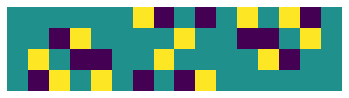

In [13]:
vis(W**2,pseudovector,cluster=False)

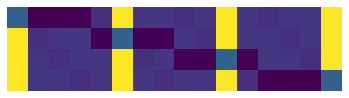

In [14]:
vis(W**2,W,cluster=False)

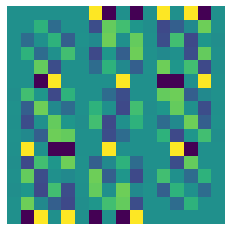

In [15]:
vis(P*W**2,W**2,cluster=False)

And of course we can verify the equivariance:

In [16]:
rin = P*W**2
rout = W**2
Q = (rin>>rout).equivariant_basis()
print(f"With equivariance error {equivariance_error(Q,rin,rout,G):.2e}")

With equivariance error 5.94e-08


We can even mix and match with the irreducible representations above.

In [17]:
P = PseudoScalar(SO(2))
W = V(SO(2))
rep = psi2>>P*W**2
print(rep)
print(rep.equivariant_basis().shape)

P⊗V²⊗𝜓₂
(8, 2)


## Additional Information 

If you really want to (for performance reasons) you can manually specify the Lie Algebra representation `drho(A)` instead of the default is calculation from `rho` using autograd as $d\rho(A) := d\rho(M)|_{M=I}(A) = \frac{d}{dt} \rho(e^{tA})|_{t=0}$. Similarly, you can override the dual representation `.T` if there is good reason.